# Global Food Shock Analysis - Work Trial

This is the jupyter notebook for showcasing the analysis for global yield decrease using the data from:

Anderson, W., W. Baethgen, F. Capitanio, P. Ciais, G. Cunha, L. Goddard, B. Schauberger , K. Sonder, G. Podesta, M. van der Velde, L. You, and Y. Ru. 2022. Twentieth Century Crop Statistics, 1900-2017. Palisades, New York: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/tmsp-sg82. Accessed 5th September 2023. 

Major objective is to derive yearly global yield decrease (considering wheat & maize separately) as well as food shock trends from 1900 till today, and to create in particular:
- world map with largest food shocks per country
- time-series of global yield decrease, including patterns/trends, & distribution plot for global yield decrease

### import libraries & set paths

In [3]:
import openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# define relevant paths
pathin_data = '../data/'
pathout_plots = '../results/plots/'

# import source code
from src import global_food_shocks as gfs

# use ALLFED style for plots
plt.style.use('../ALLFED.mplstyle')

### load & view the data

In [4]:
# load excel workbook
workbook = openpyxl.load_workbook(pathin_data+r'food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx')

# iterate through each sheet to have a look at what worksheets and columns 
# per worksheet are involved, and look into first rows of the data
for index, sheet_name in enumerate(workbook.sheetnames):
    
    # get the sheet by name
    worksheet = workbook[sheet_name]  

    # get the header row (1st or 2nd row - it's different for different worksheets)
    if index == 1:
        header_row = worksheet[1]
    else:
        header_row = worksheet[2]

    # extract column names
    column_names = [cell.value for cell in header_row] 

    # create dataframe and look into first rows
    df = pd.read_excel(pathin_data+r'food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx', 
                       sheet_name=sheet_name)  
    
    # print the sheet name, column names, and first rows of each worksheet
    print(f"sheet name: {sheet_name}")
    print("column names:", column_names)
    print("first rows of dataframe:")
    print(df.head())
    print()  # add a newline for clarity

sheet name: Title Page
column names: [None, None]
first rows of dataframe:
  Unnamed: 0                                         Unnamed: 1
0        NaN                                                NaN
1        NaN       Twentieth Century Crop Statistics, 1900-2017
2        NaN  https://sedac.ciesin.columbia.edu/data/set/foo...
3        NaN                                                NaN
4        NaN                                        August 2022

sheet name: CropStats
column names: [None, 'Harvest_year', 'admin0', 'admin1', 'crop', 'hectares (ha)', 'production (tonnes)', 'year', 'yield(tonnes/ha)', 'admin2', 'notes']
first rows of dataframe:
   Unnamed: 0  Harvest_year   admin0 admin1   crop  hectares (ha)  \
0           0          1902  Austria    NaN  wheat            NaN   
1           1          1903  Austria    NaN  wheat            NaN   
2           2          1904  Austria    NaN  wheat            NaN   
3           3          1905  Austria    NaN  wheat            NaN

## Data Preprocessing Part 1

### rename variables, extract relevant data & re-calculate missing values where possible 

The 'CropStats' sheet contains all information we need - the relevant variables for our analysis are tonnes/ha (commonly used to analyse crop yield), as well as tonnes and hectares which we'll use later for aggregating data to a global scale. 

In [5]:
# extract crop stats worksheet - all information I need is in there
crop_stats_df = pd.read_excel(pathin_data+r'food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx', 
                              sheet_name='CropStats')  

Some variables like 'admin0' or 'yield(tonnes/ha)' have ambiguous and/or problematic names (e.g., for saving), so we'll rename those more unequivocally/without backslashes or blank spaces.

In [6]:
# rename columns for convenience & to avoid problems in saving plots 
rename_mapping = {
    'admin0': 'country',
    'production (tonnes)': 'tonnes',
    'hectares (ha)': 'hectares',
    'yield(tonnes/ha)': 'yield_tonnes_per_ha',
    'admin1': 'region'
}
crop_stats_df = crop_stats_df.rename(rename_mapping, axis=1)

We extract the data we're interested in, i.e., wheat & maize as crops, and years 1900-2018. 

In [7]:
# extract only wheat & maize, as well as 1900-2018 data
crops = ['maize', 'wheat']
crop_mask = crop_stats_df['crop'].isin(crops)
crop_stats_df = crop_stats_df[crop_mask]

year_mask = (crop_stats_df['year'] >= 1900) & (crop_stats_df['year'] <= 2018)
crop_stats_df = crop_stats_df[year_mask]

print(crop_stats_df.head())


   Unnamed: 0  Harvest_year  country region   crop  hectares  tonnes  year  \
0           0          1902  Austria    NaN  wheat       NaN     NaN  1902   
1           1          1903  Austria    NaN  wheat       NaN     NaN  1903   
2           2          1904  Austria    NaN  wheat       NaN     NaN  1904   
3           3          1905  Austria    NaN  wheat       NaN     NaN  1905   
4           4          1906  Austria    NaN  wheat       NaN     NaN  1906   

   yield_tonnes_per_ha  admin2 notes  
0                 1.31     NaN   NaN  
1                 1.47     NaN   NaN  
2                 1.27     NaN   NaN  
3                 1.33     NaN   NaN  
4                 1.28     NaN   NaN  


In [8]:
# remove empty 'Unnamed: 0' column
crop_stats_df.drop(columns=['Unnamed: 0'], inplace=True)

Sometimes tonnes/ha, tonnes and/or hectares are missing, but if two of the three are given for some crop/country/region/year combination, then we can re-calculate it. 

In [9]:
# re-calculate missing tonnes, hectares or tonnes/ha where two of the three  
# variables exist for a given country/region/crop/year combination

# calculate tonnes where hectares and tonnes/ha exist, but tonnes don't
crop_stats_df = crop_stats_df.assign(tonnes=[row["tonnes"] 
                                         if not pd.isnull(row["tonnes"]) 
                                         else row["yield_tonnes_per_ha"]*row["hectares"] 
                                         for i, row in crop_stats_df.iterrows() ])

# calculate hectares where tonnes and tonnes/ha exist, but hectares don't
crop_stats_df = crop_stats_df.assign(hectares=[row["hectares"] 
                                         if not pd.isnull(row["hectares"]) 
                                         else row["tonnes"] / row["yield_tonnes_per_ha"] 
                                         for i, row in crop_stats_df.iterrows() ])

# calculate yield (tonnes/ha) where tonnes & hectares exist, but tonnes/ha doesn't
crop_stats_df['yield_tonnes_per_ha'] = crop_stats_df.apply(lambda row: 
    row['tonnes'] / row['hectares'] if (not pd.isna(row['tonnes']) and 
                                               not pd.isna(row['hectares']) and 
                                               row['tonnes'] != 0 and 
                                               row['hectares'] != 0 and
                                               pd.isna(row['yield_tonnes_per_ha'])) else 
                                               (0 if row['tonnes'] == 0 and row['hectares'] == 0 else row['yield_tonnes_per_ha']), axis=1
)

Also, we'll replace remaining zeros or blank entries in our variables of interest with NaNs - those are likely dirty data/incorrect, as countries/regions will unlikely have had suddenly zero crop yield/tonnes/hectares in a particular year, especially if before and after there was non-zero crop yield. We also replace empty entries for 'crop' by NaN.

In [10]:
# replace all remaining zeros and empty entries with NaNs
columns_to_modify = ['yield_tonnes_per_ha', 'region', 'hectares', 'tonnes', 'crop']
values_to_replace = ['', ' ', 0]
crop_stats_df = gfs.replace_values_in_columns(crop_stats_df, columns_to_modify, values_to_replace)

### aggregate over regions for particular country/year/crop combination 

Looking further into crop_stats_df, we see that countries may have multiple regions with their own time series, or that regions are NaNs or empty. As we're solely interested in country-level and global variables, we'll make our lifes easier by creating a separate dataframe ('crop_stats_country_df') where we aggregate over regions using the median (rather than the mean to be more robust w. r. t. outliers), thereby creating new country-level variables: 'yield_per_country', 'tonnes_per_country', 'hectares_per_country'.

In [11]:
# calculate the median/sum values for variables of interest per country and crop for each year 
# (i.e., across regions)
vars_to_aggregate = ['yield_tonnes_per_ha', 'tonnes', 'hectares']
aggregated_vars = ['yield_per_country', 'tonnes_per_country', 'hectares_per_country']
metrics = ['median', 'sum', 'sum']
grouping_vars = ['year', 'crop', 'country']
crop_stats_country_df = gfs.compute_aggregations(crop_stats_df, vars_to_aggregate, aggregated_vars, metrics, grouping_vars)

# replace all remaining zeros and empty entries with NaNs
crop_stats_country_df = gfs.replace_values_in_columns(crop_stats_country_df, aggregated_vars, values_to_replace)

# TODO: comment
crop_stats_country_df = crop_stats_country_df[crop_stats_country_df["year"]<2018]


### missing data

Let's inspect missing data proportions before any interpolation. 

The years available differs for each country and region, i.e., some year (ranges) are not merely NaN, but do not exist as rows in the first place. 

To get a good idea of the extent of missing data, we create a separate dataframe ('extended_crop_stats_country_df') where we make the year range consistent across countries and regions, and declare all variables as NaN (except for country, region and year), if data for that year (range) does not exist. Using the same year range for all countries/regions makes it easier to see how much data is available in which years. 

(The situation is different for crop data where missing rows may indicate that this crop does/did not grow in a given country, so we do not introduce NaN rows for completely missing crops.)

In [12]:
# extract revelant data

# crops & years of interest
crops = ['maize', 'wheat']
years_range = range(1900, 2019)

# create list of unique countries and regions
countries = crop_stats_country_df['country'].unique()

# populate the empty dataframe with all combinations of 'country' and 'region' for all years
# so that 'empty_df' contains rows for all combinations of 'country', 'region', and 'year' 
# in the range 1900-2018

empty_df = pd.DataFrame({'country': [country for country in countries for _ in years_range],
                                                'year': [y for _ in countries for y in years_range]})

# merge the empty dataframe with the original data so that it now contains rows for all 
# combinations of 'country', 'region', 'year', and columns from the original data
extended_crop_stats_country_df = pd.merge(empty_df, crop_stats_country_df, on=['country', 'year'], how='left')

We now check for missing data proportions for our variables of interest for different grouping variables (here 'country' and 'years').

We first calculate missing values for variables of interest grouped by year.

In [13]:
# calculate missing values for variables of interest grouped by year
miss_val_per_year = gfs.calc_miss_val_percentages(extended_crop_stats_country_df, aggregated_vars, crops, ['year'])

We create corresponding line plots for missing values for variables of interest grouped by year.

- tonnes/ha: most missing data for wheat from 1900 – 1920, and 1930 – 1945 (ranging roughly from 10 – 30%)
- tonnes:  most missing data for wheat until 1960 (ranging roughly from 25-40%)
- hectares:  most missing data for wheat until 1960 (ranging roughly from 25-40%)

In [14]:
# plot lineplots of missing values for variables of interest grouped by year
fig, axes = plt.subplots(3, 1, figsize=(8, 15))
for var, ax in zip(["yield_per_country", "tonnes_per_country", "hectares_per_country"], axes.flatten()):
    sns.lineplot(data=miss_val_per_year, x="year", y=var, hue="crop", ax=ax)
    ax.set_ylabel("missing (%)")
    ax.set_title(f"missing data (%) across time for {var}")

We now calculate missing values for variables of interest grouped by year.

In [15]:
# calculate missing values for variables of interest grouped by country
miss_val_per_country = gfs.calc_miss_val_percentages(extended_crop_stats_country_df, aggregated_vars, crops, ['country'])

We create corresponding bar plots for missing values for variables of interest grouped by country.

- tonnes/ha: most missing data for wheat in the Czech Republic, Finland, Belgium (roughly 10-20%)
- tonnes: most missing data for wheat in Croatia, Czech Republic, Finland, Austria, Belgium (50-80%)
- hectares: most missing data for wheat in Croatia, Czech Republic, Finland, Austria, Belgium (50-80%)

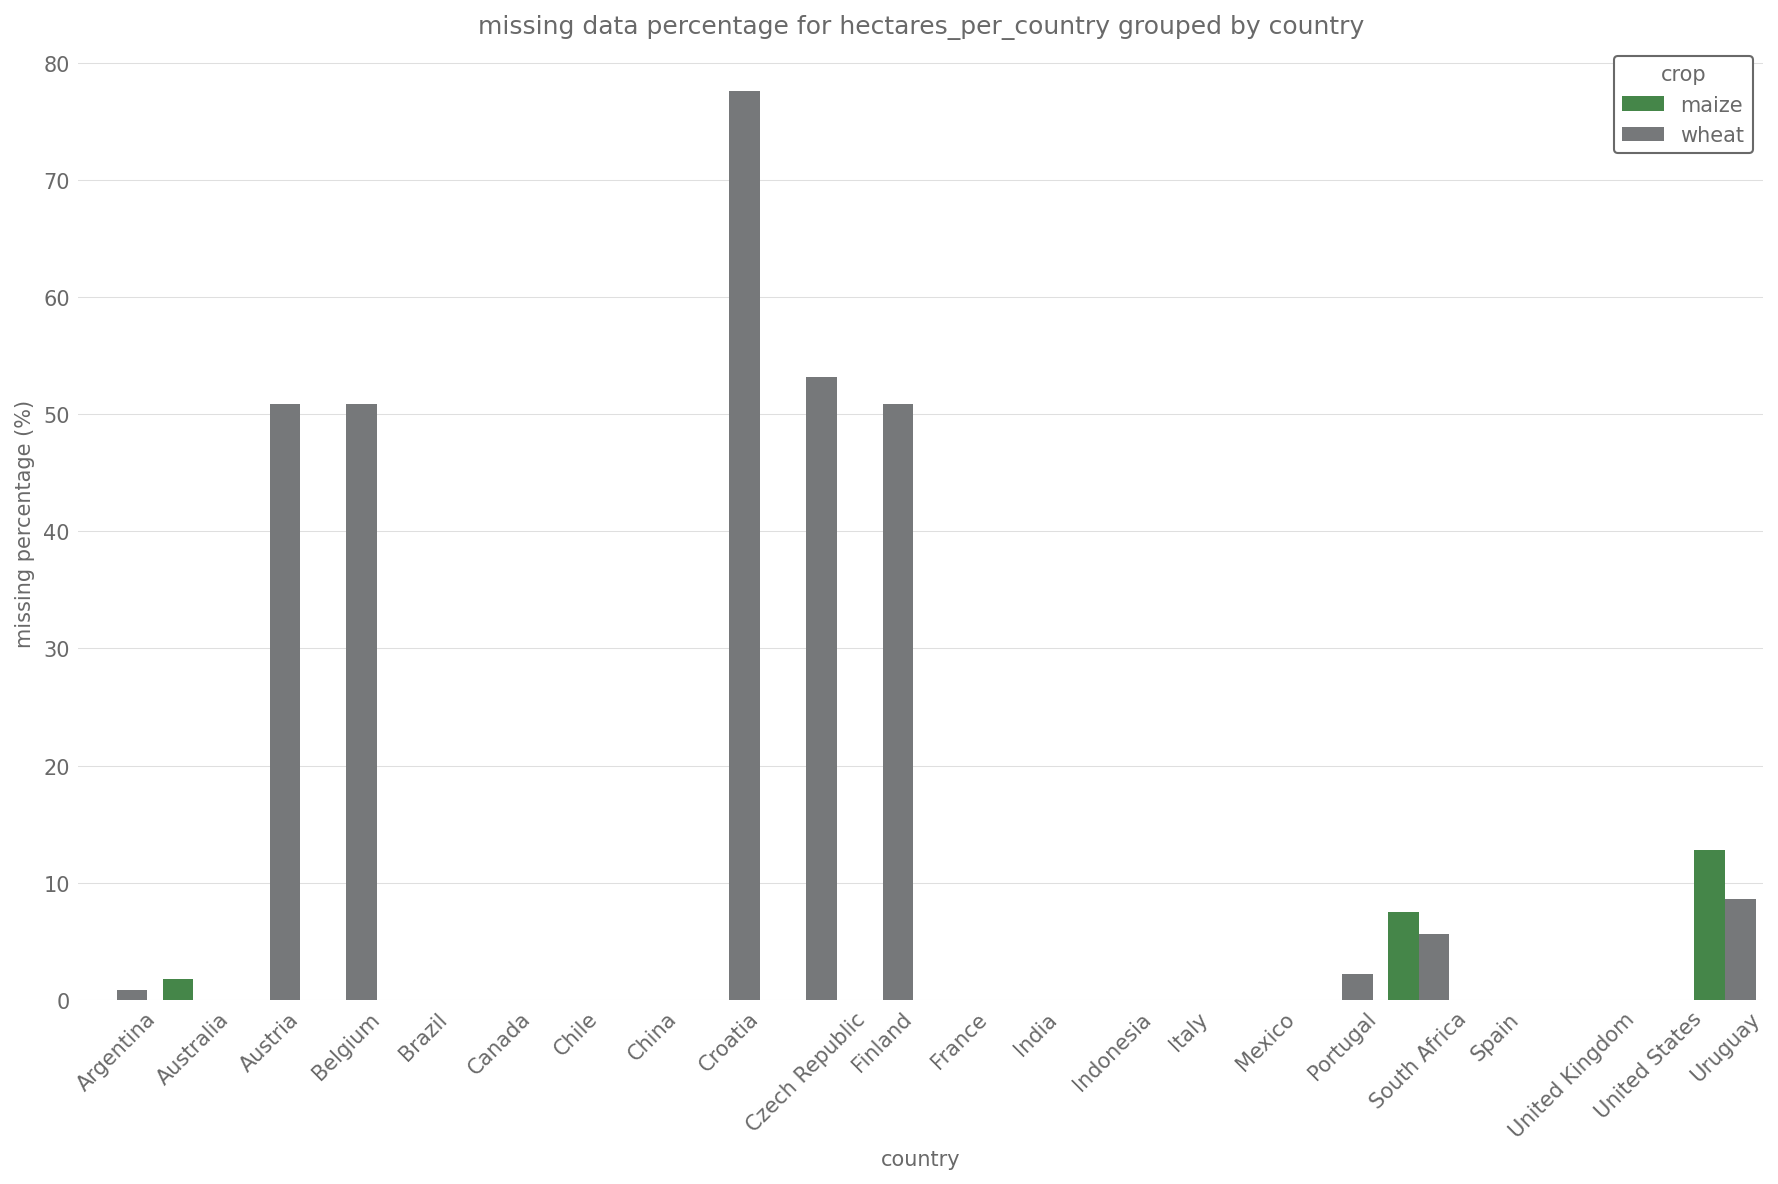

In [16]:
# plot barplots of missing values for variables of interest grouped by country
gfs.plot_miss_val_percentages(miss_val_per_country, aggregated_vars, crops, ['country'], pathout_plots)

## Exploratory Data Analysis

To get an idea of distributions and time trajectories of our yield data, we plot both distributions and time series of 'yield_per_country' grouped one time by country, and one time by year.

We first have a look at yield distributions for each country (i.e., across years) which shows strongly left-skewed and sometimes bimodal distributions.

In [17]:
# get distributions of yield per country across years for each country
gfs.plot_histograms(crop_stats_country_df, 'yield_per_country', 'country', crops, 5, pathout_plots)

We now have a look at yield distributions for years (i.e., across countries), and divide the data into 5-year periods for ease. 

In [18]:
# create new variable 'year_section'
crop_stats_country_df['year_section'] = ((crop_stats_country_df['year'] - crop_stats_country_df['year'].min()) // 5) * 5

We plot the distributions of median yield, grouped by year sections which shows strongly left-skewed and sometimes bimodal distributions.

In [19]:
# get distributions of yield per country for each 5-year period
gfs.plot_histograms(crop_stats_country_df, 'yield_per_country', 'year_section', crops, 5, pathout_plots)

We plot time-series of median yield for each country with confidence intervals using seaborns bootstrapping functionality. 

All time series are non-stationary and increase as a global trend, and often variances increase over time for both crops.

/home/nadinespy/Desktop/ALLFED-Global-Food-Shock-Analysis/venv/lib/python3.8/site-packages/src/global_food_shocks.py:220: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/home/nadinespy/Desktop/ALLFED-Global-Food-Shock-Analysis/venv/lib/python3.8/site-packages/src/global_food_shocks.py:220: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/home/nadinespy/Desktop/ALLFED-Global-Food-Shock-Analysis/venv/lib/python3.8/site-packages/src/global_food_shocks.py:220: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/home/nadinespy/Desktop/A

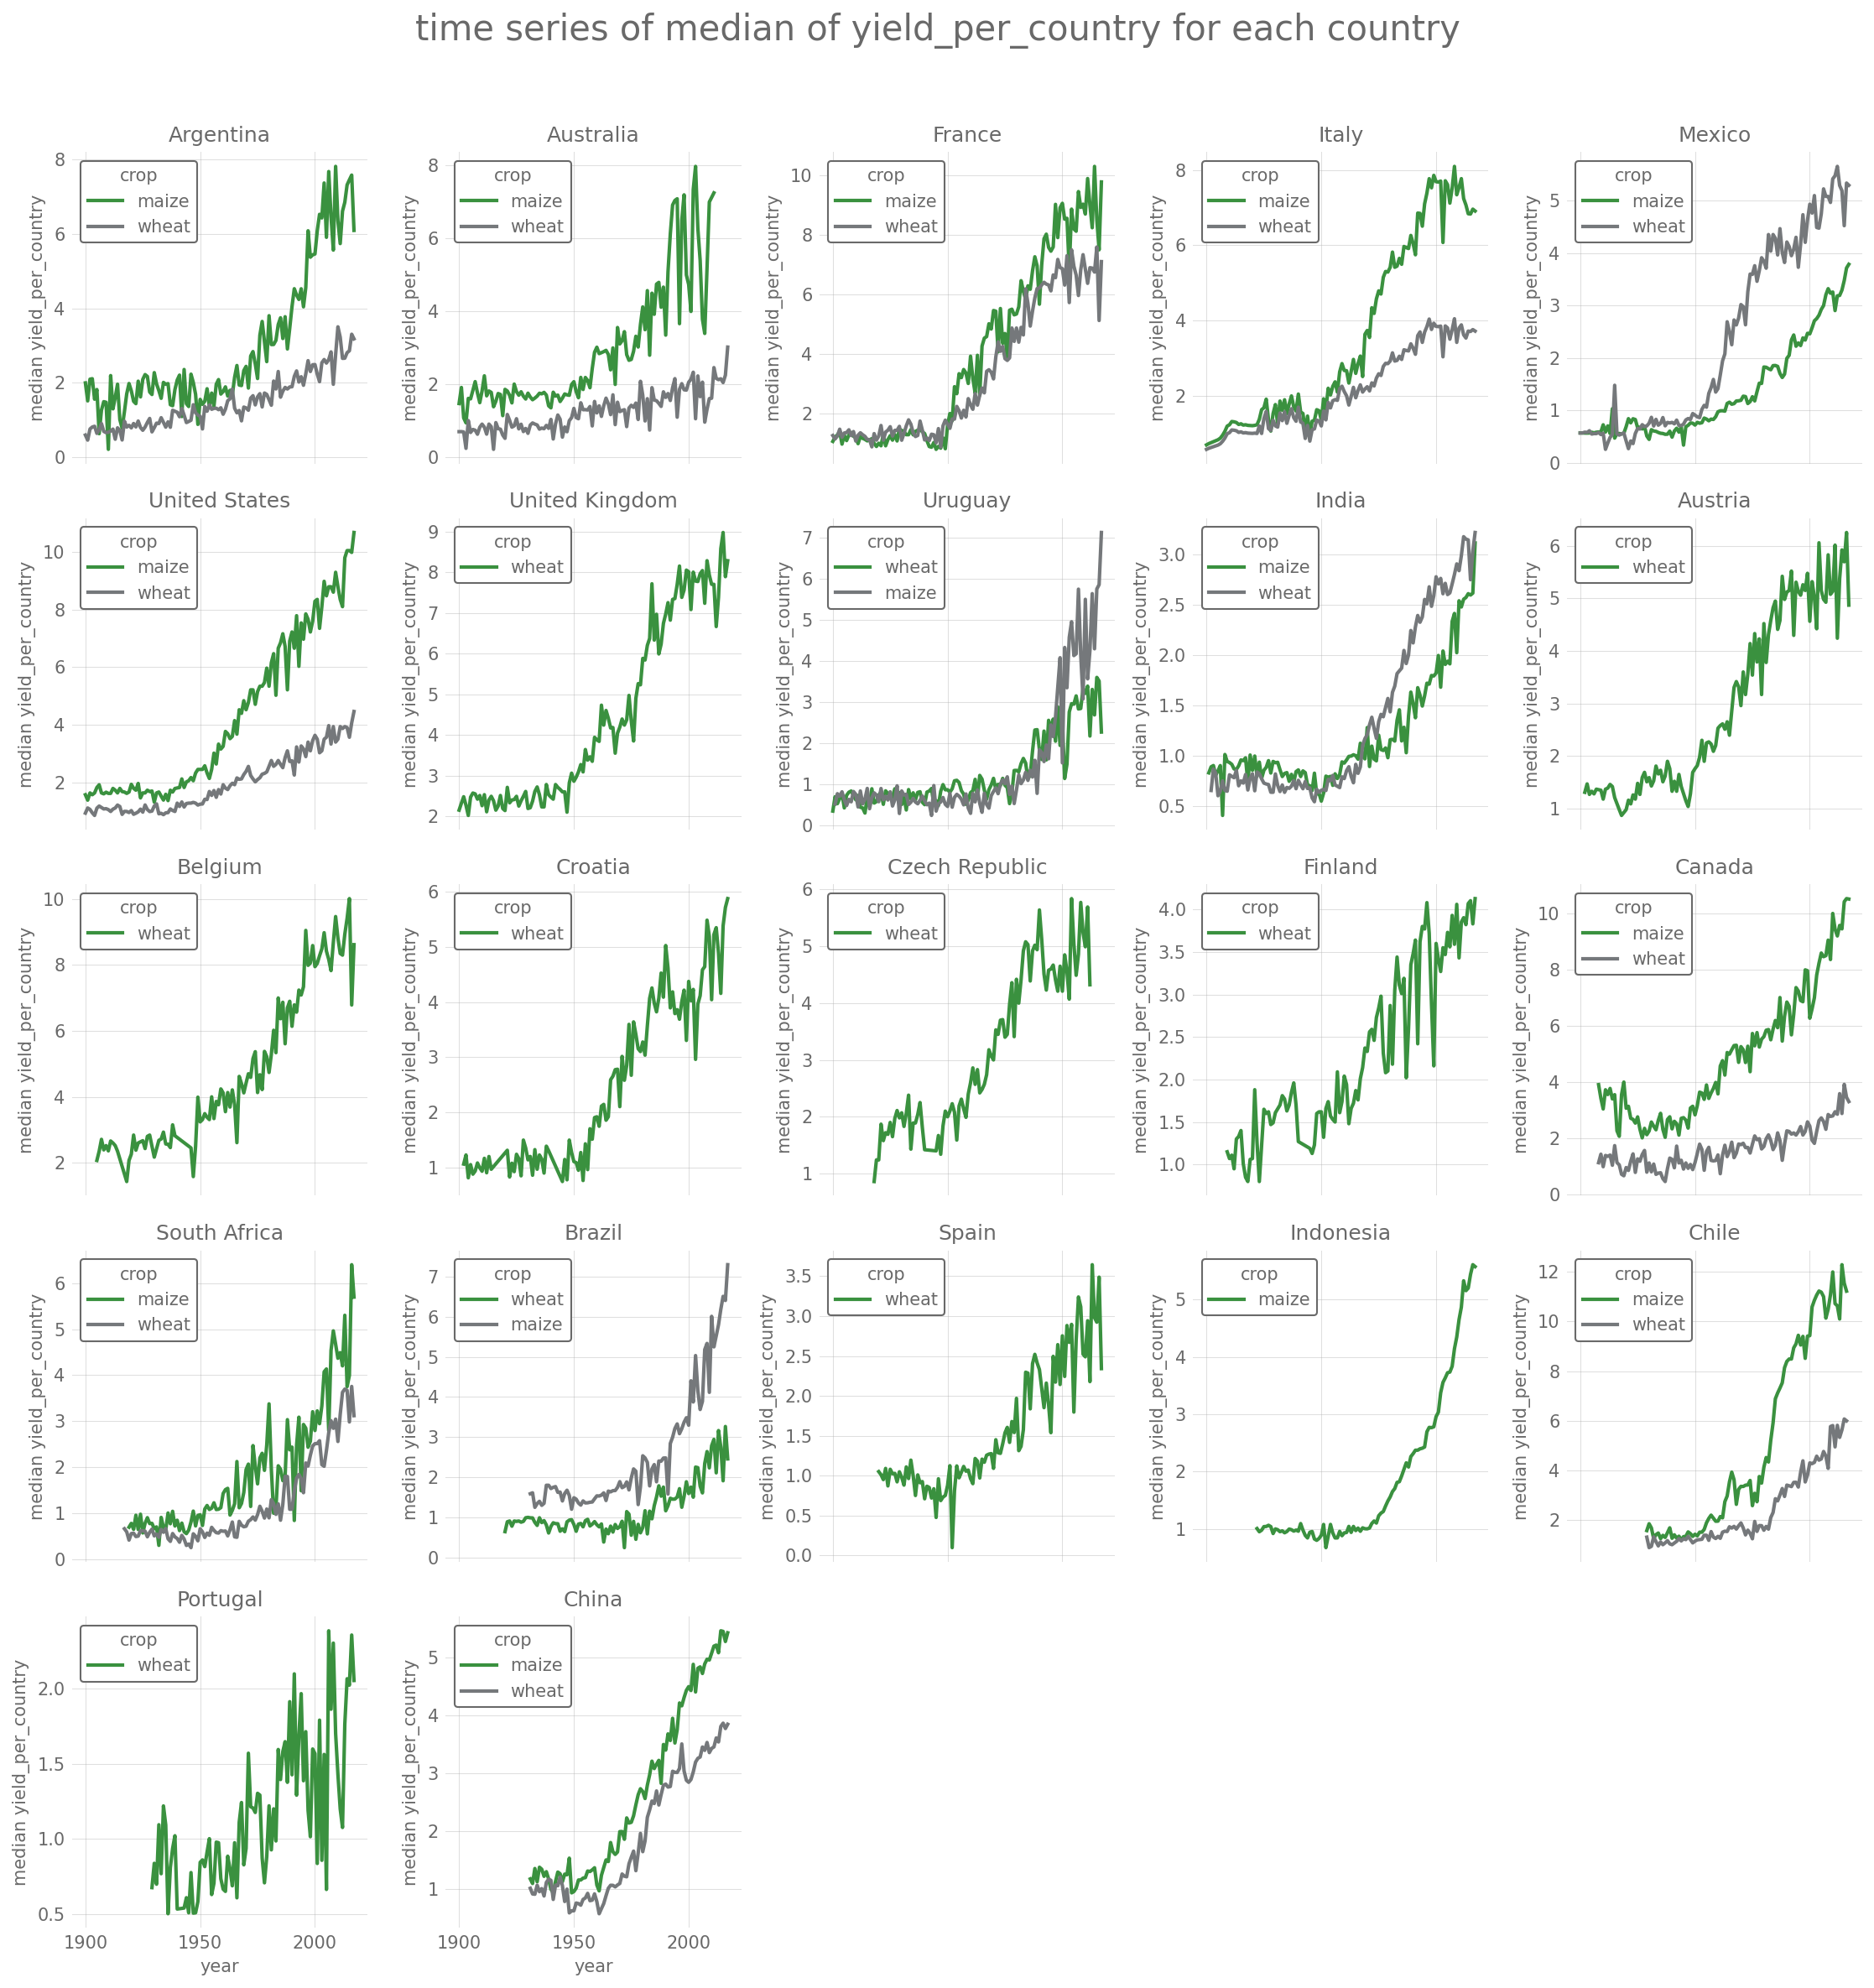

In [20]:
# get time-series of median yield (tonnes/ha) for each country
gfs.plot_time_series_by_group(crop_stats_country_df, 'yield_per_country', pathout_plots, crops, group_var='country',
                              metric='median', num_rows=5)

We now plot the time-series of median global yield for each country equally with confidence intervals using seaborns bootstrapping functionality. 

We equally see a non-stationary time series that increases as a global trend, and variances increase over time for both crops (also shown by widening confidence intervals).

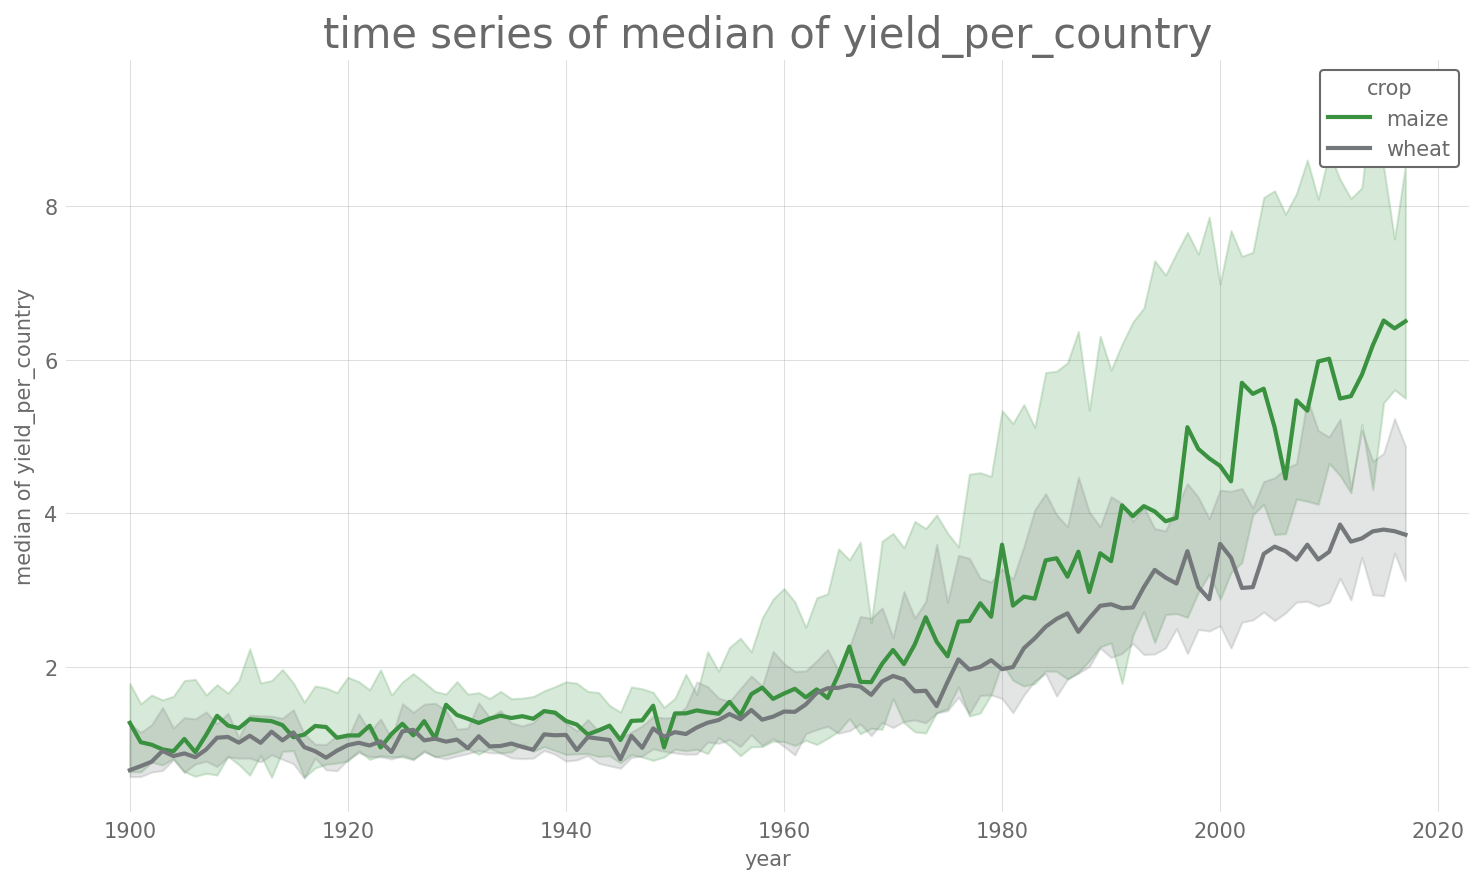

In [21]:
# get time-series of global median yield (tonnes/ha)
gfs.plot_time_series_by_group(crop_stats_country_df, 'yield_per_country', pathout_plots, crops, group_var=None,
                              metric='median', num_rows=1)

Conclusions:

- Missing values: 
    * Looking at the time series of yield per country, missing data are not overly concerning - most data is missing from 1900 - 1950, but it seems that trajectories in this period have been fairly stable (either low yield, or slow, mostly linear increase), and most drastic changed occurred afterwards (partially non-linear increase and higher variance across years).

    * Many countries lack maize data, but these countries are rather small, thus ideally, they will play a smaller role in the aggregated data, and there are enough other countries where maize data exists. 

    * Interpolation will also decrease missing data proportions. 

- Trends: We can already detect trends in the above time series plots: country-level as well as global yield increase over time (with a quicker increase as of ~1950/60), and - relevant for our year-to-year change analysis later on - the variance does clearly increase over time, too, i.e., values change more drastically from year to year in the second half of the 21st century.  

## Data Processing Part 2

We will now handle missing values in a simple way, i.e., by: 
- ignoring values at the start and end of the time period considered (1900-2018)/not replacing them, 
- interpolating missing values in between using linear interpolation, i.e., the previous existing value is taken as one end of the range, and the next existing value as the other, and a sequence of evenly spaced numbers in between is generated;
    * although there's, in general, the risk that interpolation occurs in a too big gap using this method, because one datapoint exists at the start and end of a long time period, respectively, we can exlude it here, because we've seen in the time series that data exists fairly regularly in between start and end points,
- using more complex methods such as forecasting (e. g., with AutoRegressive Integrated Moving Average (ARIMA)) or non-linear interpolation did not yield superior results (i.e., less NaNs, or better interpolation), so we stick to a simple, but equally good solution.

Let's first copy our existing dataframe and check the number of NaNs before interpolation.

In [22]:
# create a copy of the original country dataframe
new_crop_stats_country_df = crop_stats_country_df.copy()
print('total number of NaNs before interpolation: ', new_crop_stats_country_df['yield_per_country'].isna().sum())

total number of NaNs before interpolation:  80


Let's now interpolate country-wise and check remaining NaNs.

In [23]:
unique_countries = new_crop_stats_country_df['country'].unique().tolist()

for country in unique_countries:
    for crop in crops:
        mask = (new_crop_stats_country_df['country'] == country) & (new_crop_stats_country_df['crop'] == crop)

        if mask.sum() > 0:  # ensure we have rows for this country-crop combination
            original_na_count = new_crop_stats_country_df.loc[mask, 'yield_per_country'].isna().sum()
            
            # if there are NaN values, attempt interpolation
            if original_na_count > 0:
                filled_series = gfs.interpolate_series(new_crop_stats_country_df.loc[mask, 'yield_per_country'].copy())
                new_na_count = filled_series.isna().sum()

                # print to see if interpolation has been effective
                if original_na_count != new_na_count:
                    print(f"Country: {country}, Crop: {crop} - NaNs before: {original_na_count}, NaNs after: {new_na_count}")

                new_crop_stats_country_df.loc[mask, 'yield_per_country'] = filled_series

# check remaining NaNs
print('total number of NaNs after interpolation: ', new_crop_stats_country_df['yield_per_country'].isna().sum())

Interpolation occurred!
Country: Argentina, Crop: wheat - NaNs before: 1, NaNs after: 0
Interpolation occurred!
Country: Australia, Crop: maize - NaNs before: 2, NaNs after: 0
Interpolation occurred!
Country: Austria, Crop: wheat - NaNs before: 3, NaNs after: 0
Interpolation occurred!
Country: Belgium, Crop: wheat - NaNs before: 14, NaNs after: 3
Interpolation occurred!
Country: Croatia, Crop: wheat - NaNs before: 11, NaNs after: 0
Interpolation occurred!
Country: Czech Republic, Crop: wheat - NaNs before: 20, NaNs after: 16
Interpolation occurred!
Country: Finland, Crop: wheat - NaNs before: 13, NaNs after: 7
Interpolation occurred!
Country: Portugal, Crop: wheat - NaNs before: 2, NaNs after: 0
total number of NaNs after interpolation:  40


Some NaNs may remain as they may exist either before or after the last existing datapoint.

## Global Yield Decrease Analysis  

We now aggregate the country data to get a time series of global yield as well as a time series of yearly change, i.e., the change in tonnes/ha in a given year compared to the previous year. 
- As tonnes/ha is a relative metric where country size does not play a role (but it should in a variable like global scale yield decrease), we want to use a simple weighting procedure: we include in our analysis only those countries that collectively contribute to 95% of the world's tonnes of crops in 2010 (the total amount of tonnes does reflect a country's size).
- This is similar to Andersen et al.'s approach where they determined breadbaskets using a 90% threshold for collective contributions to crop tonnes.

To investigate/denote trends, we mark yield changes that fall either below or above the decile, and do a linear regression to see whether specific years or countries influence global yield change. 
- More complex methods such as ARIMA, time series decompositions or other forecasting methods didn't seem suitable, as, given what the time-course of yearly change looks like, they would either not be reasonable, or the benefits marginal.

### aggregate country data for global scale analysis & plot new time series

We include only countries in our analysis, if they collectively contribute to 95% of crop yield (tonnes) in 2010.

In [24]:
# include country in analysis only if it contributes to 95% of crop yield (tonnes) in 2010
new_crop_stats_country_df_2010 = new_crop_stats_country_df[new_crop_stats_country_df['year'] == 2010]
total_tonnes_by_country = new_crop_stats_country_df_2010.groupby(
    'country')['tonnes_per_country'].sum().sort_values(ascending=False) # calculate total tonnes by country for 2010
cumsum_tonnes = total_tonnes_by_country.cumsum()                        # calculate cumulative sum
cutoff_95_percent = total_tonnes_by_country.sum() * 0.95                # determine 95% cutoff
top_countries = cumsum_tonnes[cumsum_tonnes <= cutoff_95_percent].index # get countries that make up the first 90%
new_crop_stats_country_df = new_crop_stats_country_df[new_crop_stats_country_df['country'].isin(top_countries)]


We now aggregate country data to get global yield.

In [25]:
# calculate the median/sum values for variables of interest per crop for each year across countries
variables_to_compute = ['yield_per_country']
new_variable_names = ['global_yield']
metrics = ['median']
grouping_columns = ['year', 'crop']
new_crop_stats_global_df = gfs.compute_aggregations(new_crop_stats_country_df, variables_to_compute, new_variable_names, metrics, grouping_columns)

Let's have another look at the time series of just the countries that collectively contribute to 95% of the world's crop tonnes.

In [26]:
# get new time-series of yield (tonnes/ha) per country for new list of countries
gfs.plot_time_series_by_group(new_crop_stats_country_df, 'yield_per_country', pathout_plots, crops, group_var='country',
                              metric='median',num_rows=5)

/home/nadinespy/Desktop/ALLFED-Global-Food-Shock-Analysis/venv/lib/python3.8/site-packages/src/global_food_shocks.py:220: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/home/nadinespy/Desktop/ALLFED-Global-Food-Shock-Analysis/venv/lib/python3.8/site-packages/src/global_food_shocks.py:220: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/home/nadinespy/Desktop/ALLFED-Global-Food-Shock-Analysis/venv/lib/python3.8/site-packages/src/global_food_shocks.py:220: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=data_for_group, x="year", y=y_var, hue='crop', ci=95, estimator=metric, ax=axes[i])
/home/nadinespy/Desktop/A

Let's now look at the global yield time series. 

It seems that the variance increase over time gets a bit lost for wheat in the global aggregate while a clear increase is still visible for maize. 

This may be in part due to the fact that during the aggregation, we eliminated some countries with increasing variance (e. g., Uruguay). At the same time, looking at the above country time series of countries that collectively contribute to 95% of crop tonnes, some countries do, and some countries do not, display a variance increase over time for wheat, but it seems that this gets cancelled out in the aggregation.

In [27]:
# get new time-series of global yield (tonnes/ha) for new list of countries
gfs.plot_time_series_by_group(new_crop_stats_global_df, 'global_yield', pathout_plots, crops,
                              metric='median',num_rows=5)

### yearly change in global yield & trend analysis

We now calculate yearly change in median global yield by comparing pairs of consecutive years (storing values in 'global_yield_change'), and do a simple anomaly detection by looking at datapoints in the upper and lower deciles, respectively. 

Taking into account the full distribution of crop yield over time to detect anomalous values rather than defining them as, e.g., a 10% decrease compared to a previous time-point seems more suitable to detect trends over longer time scales.

In [28]:
# calculate yearly change
new_crop_stats_global_df['global_yield_change'] = new_crop_stats_global_df.sort_values("year", ascending=True).groupby('crop')['global_yield'].diff()

# we exclude 1900, as there is no previous time-point to compare it to
new_crop_stats_global_df = new_crop_stats_global_df[new_crop_stats_global_df['year'] != 1900]

We plot the time series of yearly global yield change, and mark datapoints that fall either above or below the upper and lower deciles, respectively. 

It seems that yearly change remains fairly stable for wheat, but not for maize. 

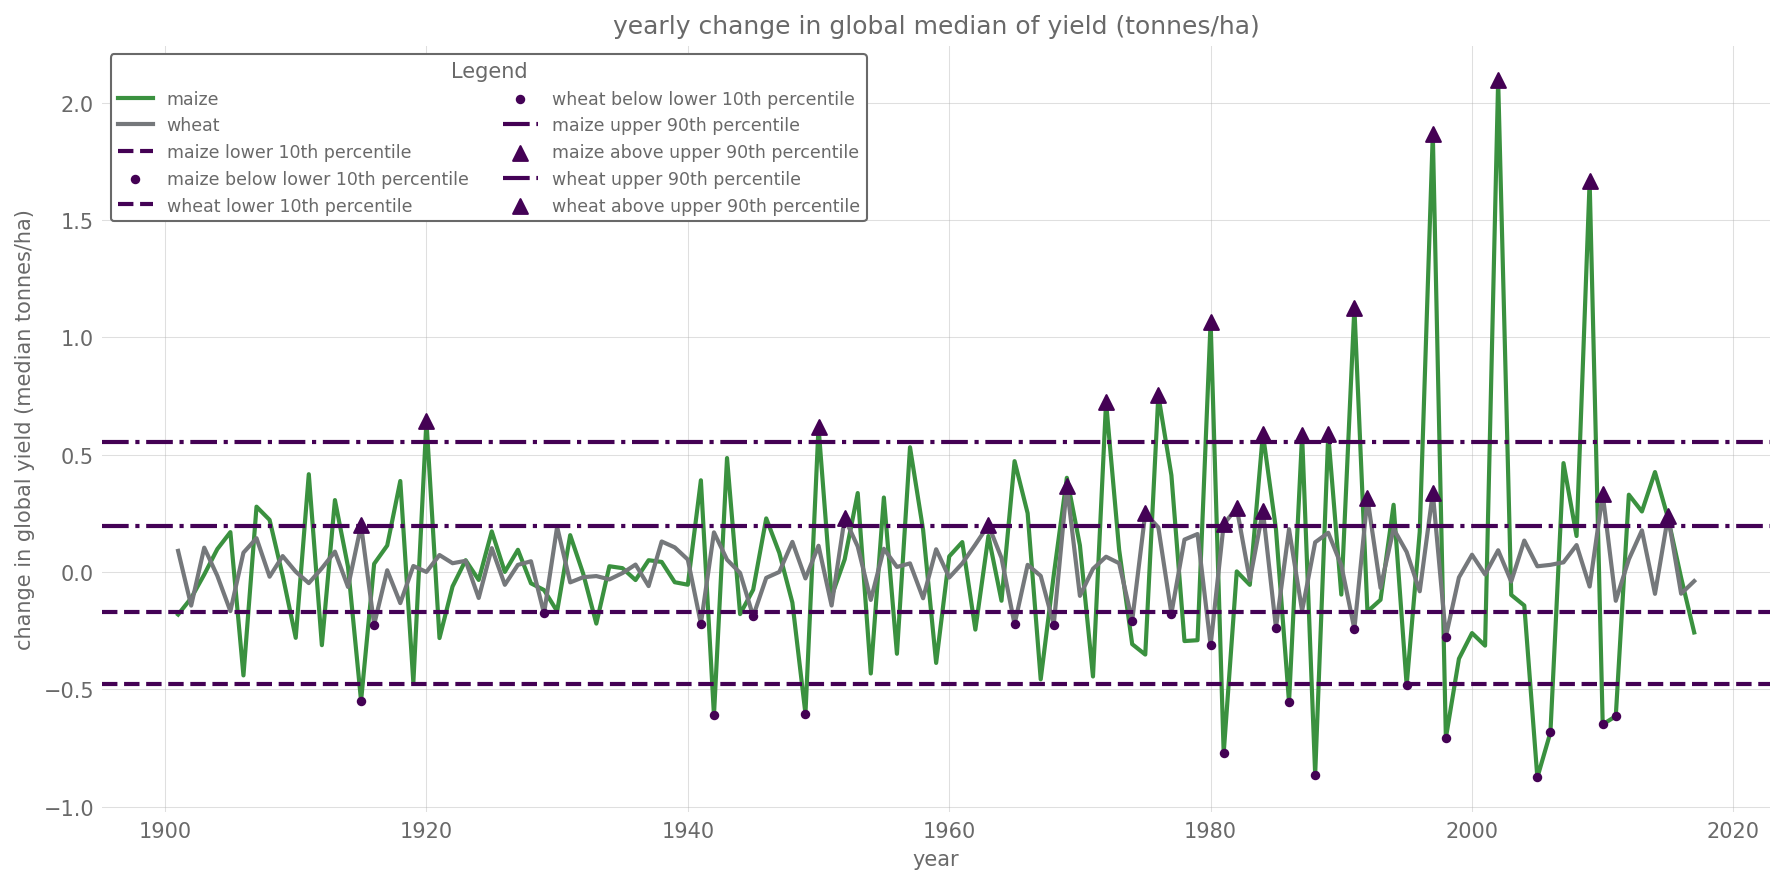

In [29]:
# plot time series of yearly global yield change, including upper and lower deciles
gfs.plot_global_yield_change(new_crop_stats_global_df, 0.1, 0.9, pathout_plots)


Let's look at a summary table where we print out, separately for each crop, the total number of datapoints falling above or below the decile, respectively, as well as the datatpoints themselves (including what year they belong to).

In [30]:
# create a dictionary to store information about data points below and above deciles
data_points_info = {}

# calculate the lower and upper deciles for each crop
lower_deciles = new_crop_stats_global_df.groupby('crop')['global_yield_change'].quantile(0.1).to_dict()
upper_deciles = new_crop_stats_global_df.groupby('crop')['global_yield_change'].quantile(0.9).to_dict()

# iterate through each crop
for crop, decile in lower_deciles.items():
    # data points below the lower decile
    below_decile = new_crop_stats_global_df[(new_crop_stats_global_df['crop'] == crop) & (new_crop_stats_global_df['global_yield_change'] < decile)]
    
    # store the information
    data_points_info[f"{crop} below lower decile"] = {
        "total data points": len(below_decile),
        "data points": below_decile[['year', 'global_yield_change']]
    }

for crop, decile in upper_deciles.items():
    # data points above the upper decile
    above_decile = new_crop_stats_global_df[(new_crop_stats_global_df['crop'] == crop) & (new_crop_stats_global_df['global_yield_change'] > decile)]
    
    # store the information
    data_points_info[f"{crop} above upper decile"] = {
        "total data points": len(above_decile),
        "data points": above_decile[['year', 'global_yield_change']]
    }

# print the information for each crop
for crop, info in data_points_info.items():
    print(f"crop: {crop}")
    print(f"total data points: {info['total data points']}")
    print("data points:")
    print(info['data points'])
    print("\n")

print(data_points_info)

crop: maize below lower decile
total data points: 12
data points:
     year  global_yield_change
30   1915            -0.549867
84   1942            -0.611245
98   1949            -0.604308
162  1981            -0.773000
172  1986            -0.555000
176  1988            -0.864000
190  1995            -0.483000
196  1998            -0.708000
210  2005            -0.876236
212  2006            -0.684055
220  2010            -0.650000
222  2011            -0.615000


crop: wheat below lower decile
total data points: 12
data points:
     year  global_yield_change
33   1916            -0.224525
59   1929            -0.177329
83   1941            -0.220539
91   1945            -0.188947
131  1965            -0.223375
137  1968            -0.224813
149  1974            -0.207549
155  1977            -0.177452
161  1980            -0.312898
171  1985            -0.238261
183  1991            -0.243403
197  1998            -0.275530


crop: maize above upper decile
total data points: 12
data 

It seems that more recent years have exhibited outliers in both upper and lower decile for maize, while outliers for wheat seem more evenly distributed across years.

Let's visualize this by creating a time series of datapoints in the upper and lower decile, respectively.

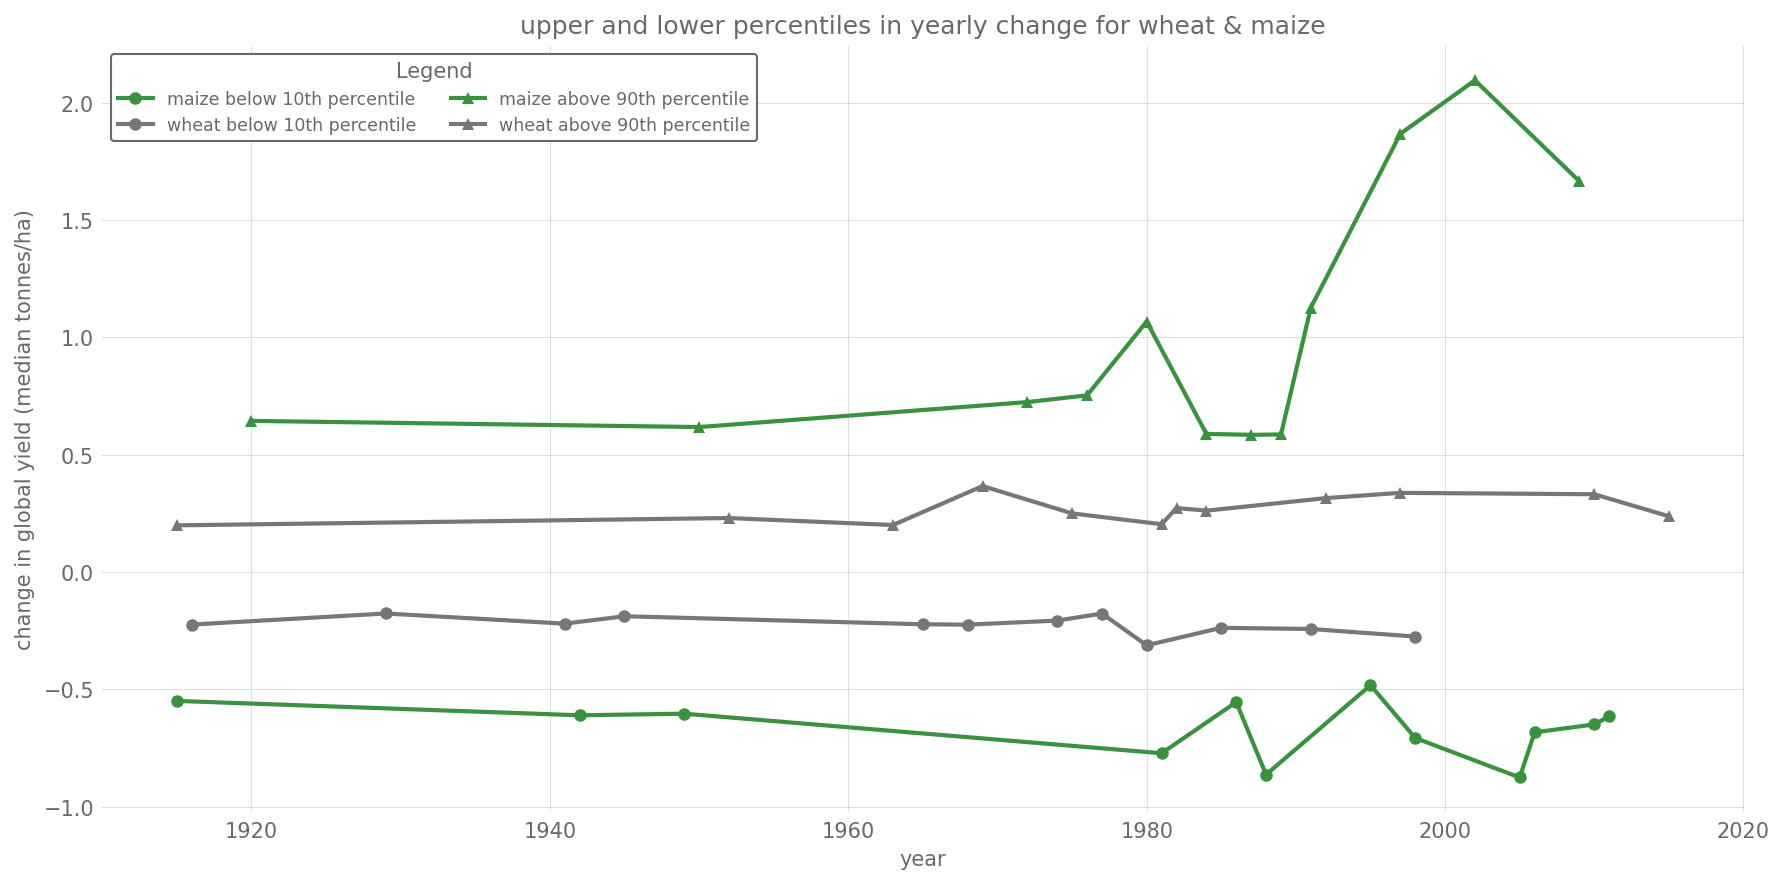

In [31]:
# plot time series of datapoints in the upper and lower decile, respectively
gfs.plot_envelope_global_yield_change(new_crop_stats_global_df, 0.1, 0.9, pathout_plots)

To get a better idea of how the variance changes over time, let's also look at the time series of data points in the lower and upper quartile.

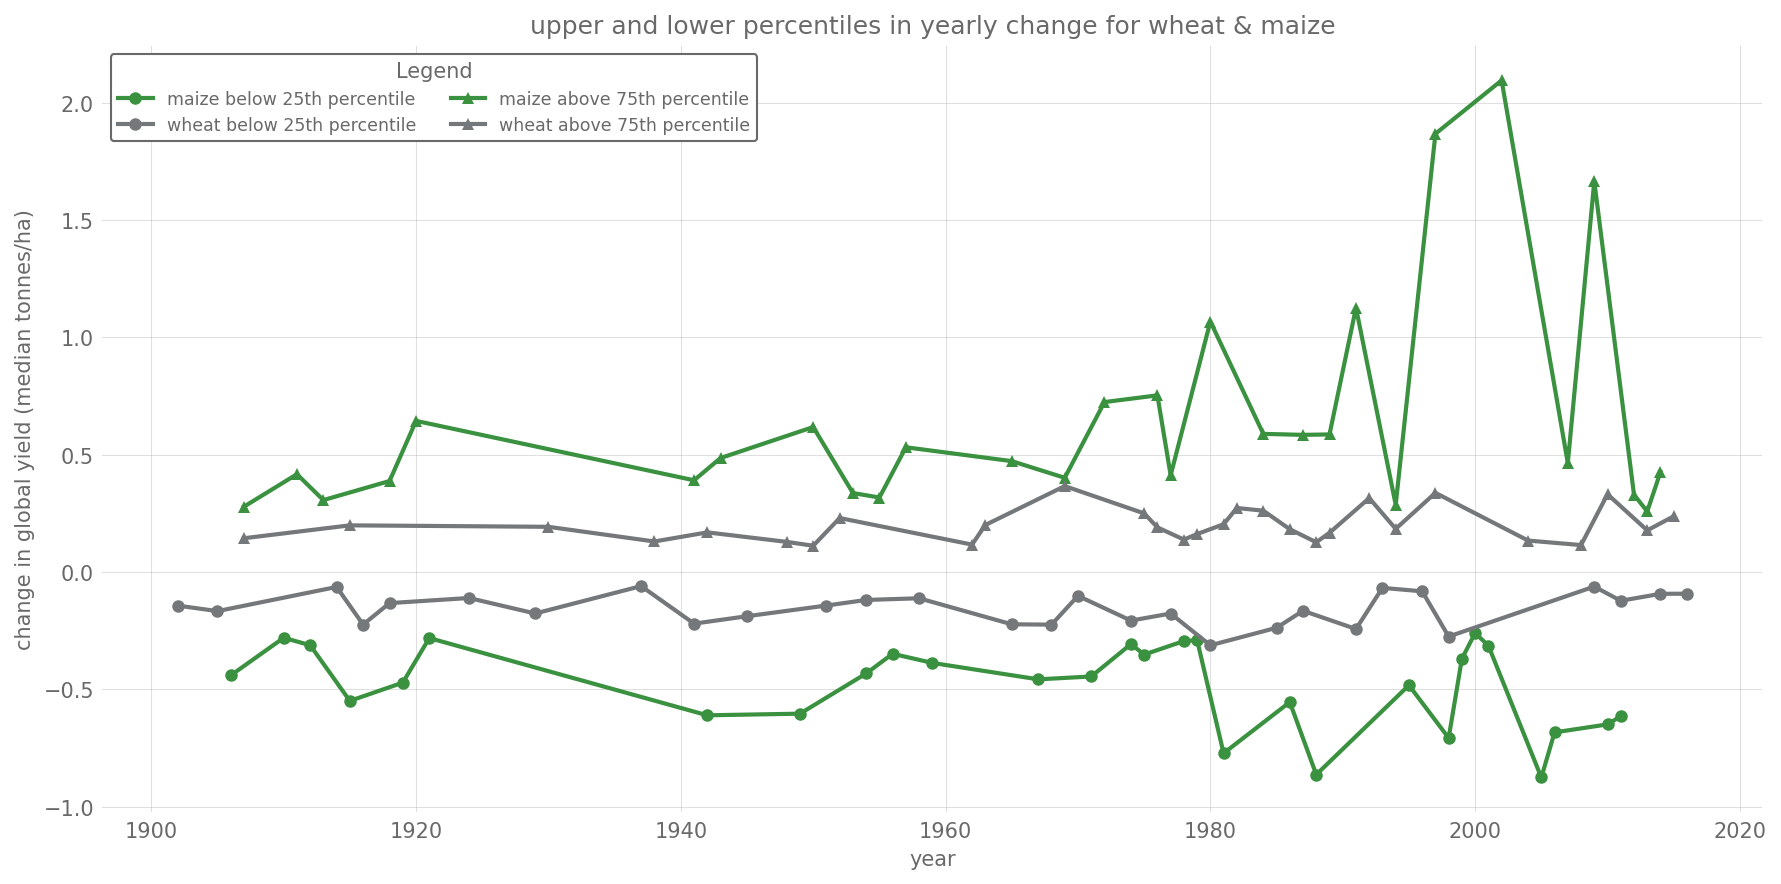

In [32]:
# plot time series of datapoints in the upper and lower quartile, respectively
gfs.plot_envelope_global_yield_change(new_crop_stats_global_df, 0.25, 0.75, pathout_plots)

### distribution of global food decrease

We create histograms to visualize the global yield decrease distribution separately for crop (note, it's only the decrease, not both increase and decrease).

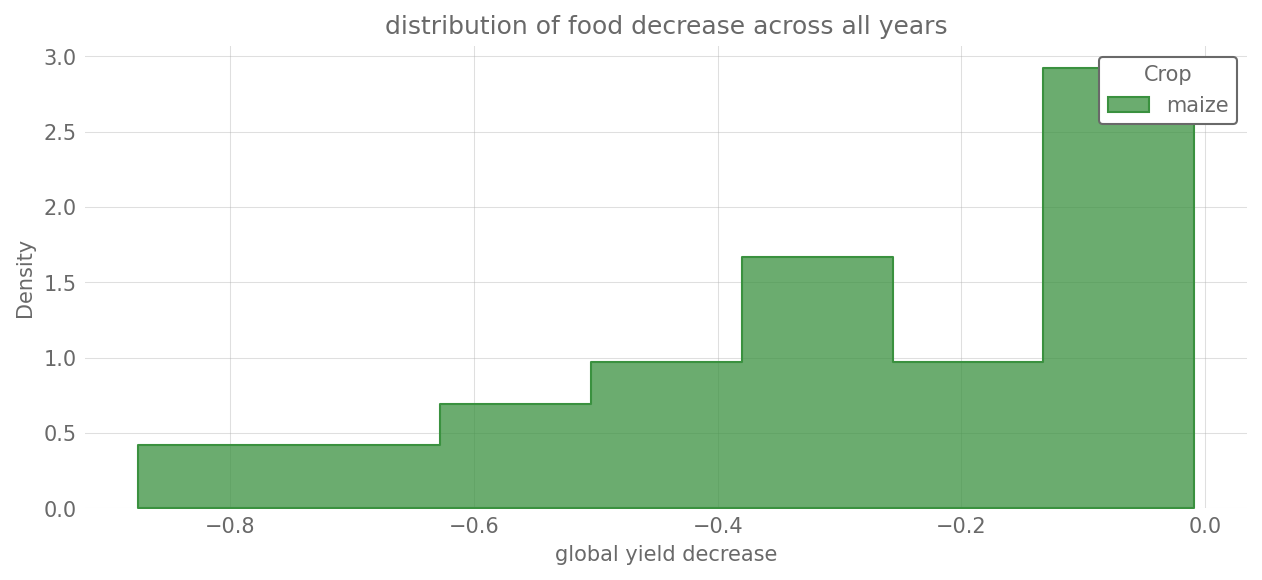

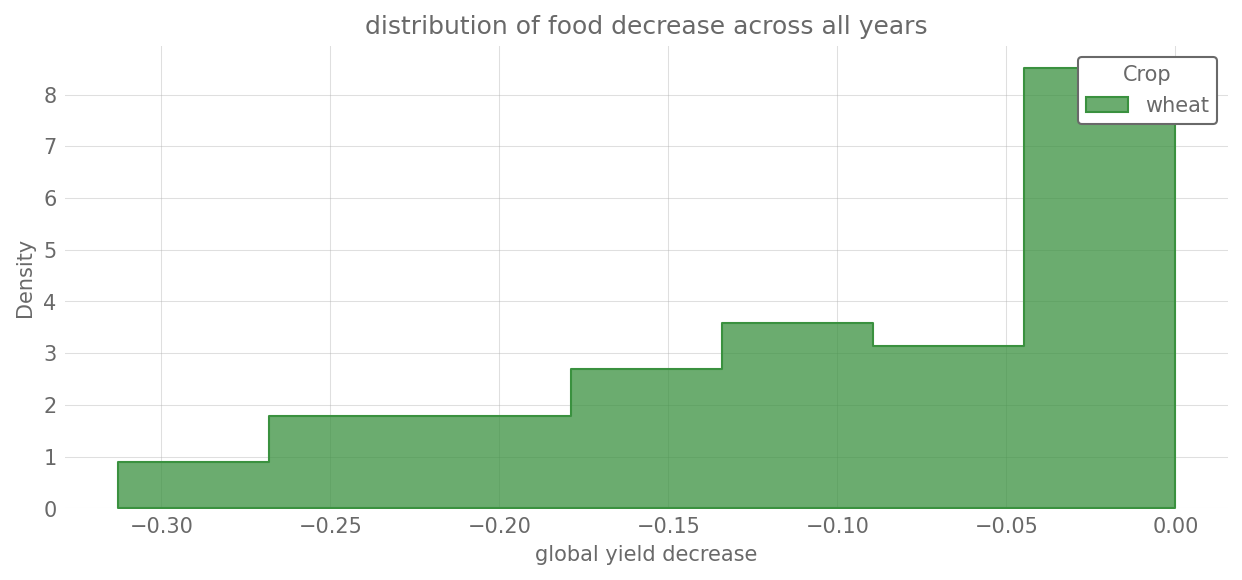

In [33]:
for crop in crops:
    subset = new_crop_stats_global_df[(new_crop_stats_global_df['crop'] == crop) & (new_crop_stats_global_df['global_yield_change'] < 0)]
    sns.histplot(data=subset, x="global_yield_change", label=crop, element="step", stat="density")

    plt.title('distribution of food decrease across all years')
    plt.xlabel('global yield decrease')
    plt.ylabel('Density')
    plt.legend(title="Crop")

    plt.savefig(f"{pathout_plots}distr_food_shocks_{crop}.png", bbox_inches='tight', dpi=300)
    plt.show()


### world map with largest food decrease per country

We create a world map, separately for crop type, to visualize the largest yield decrease per country experienced so far (stored in 'yearly_yield_change').

/tmp/ipykernel_954603/3537643820.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


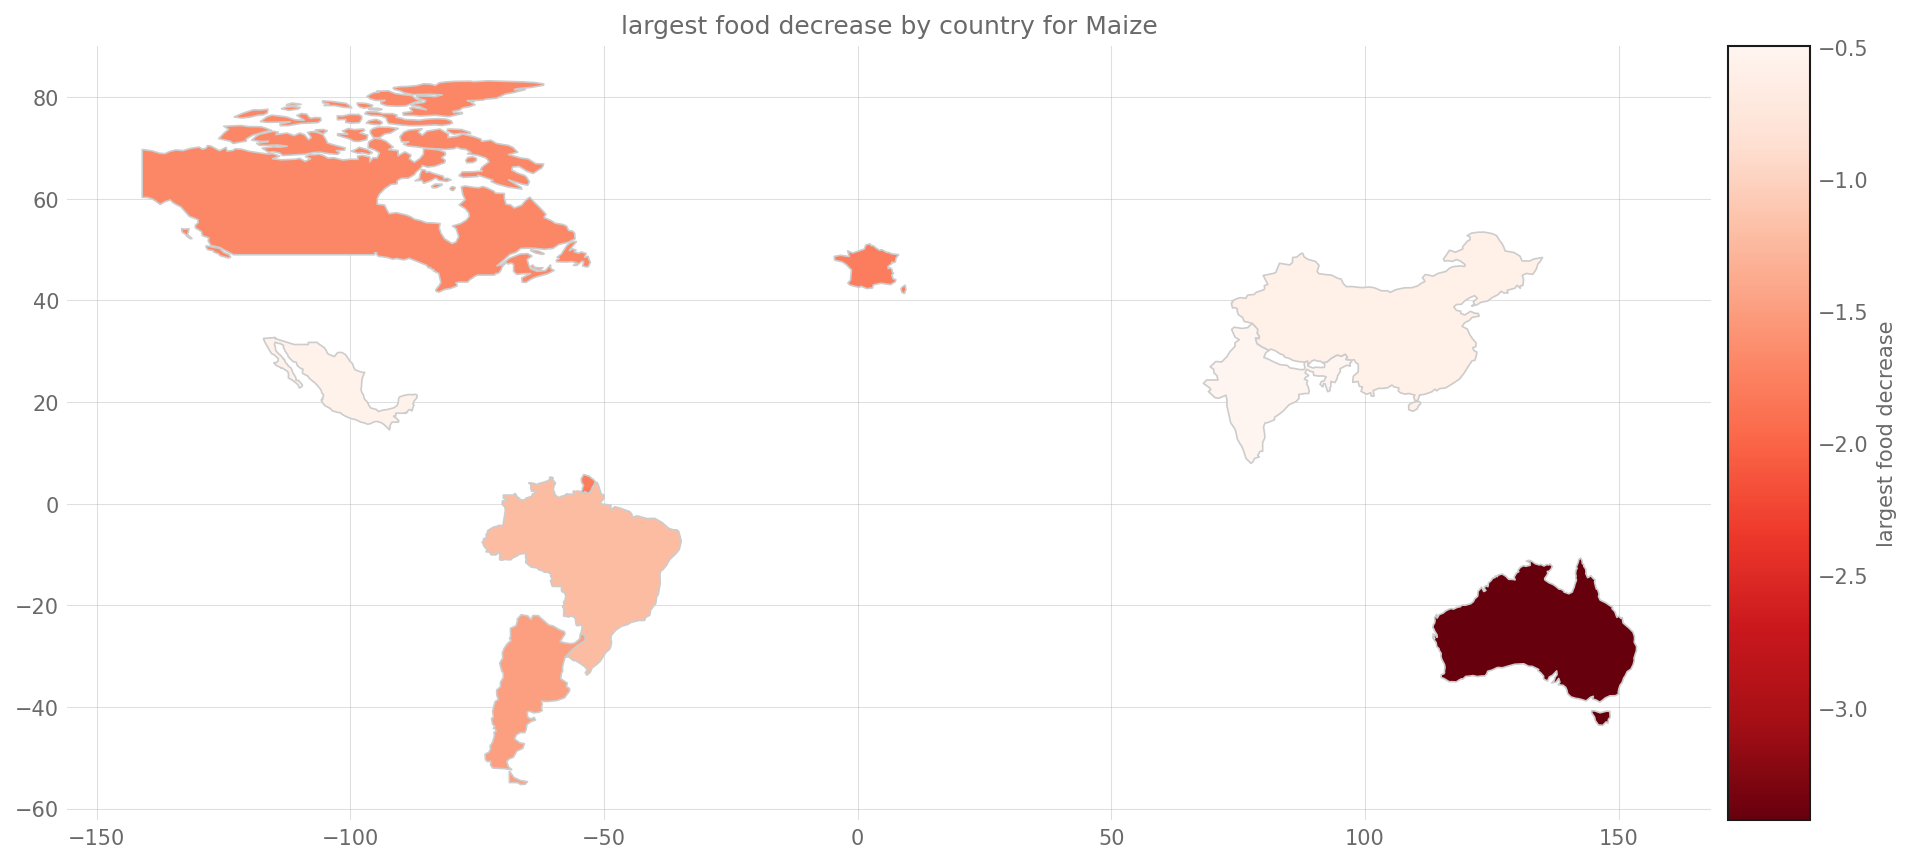

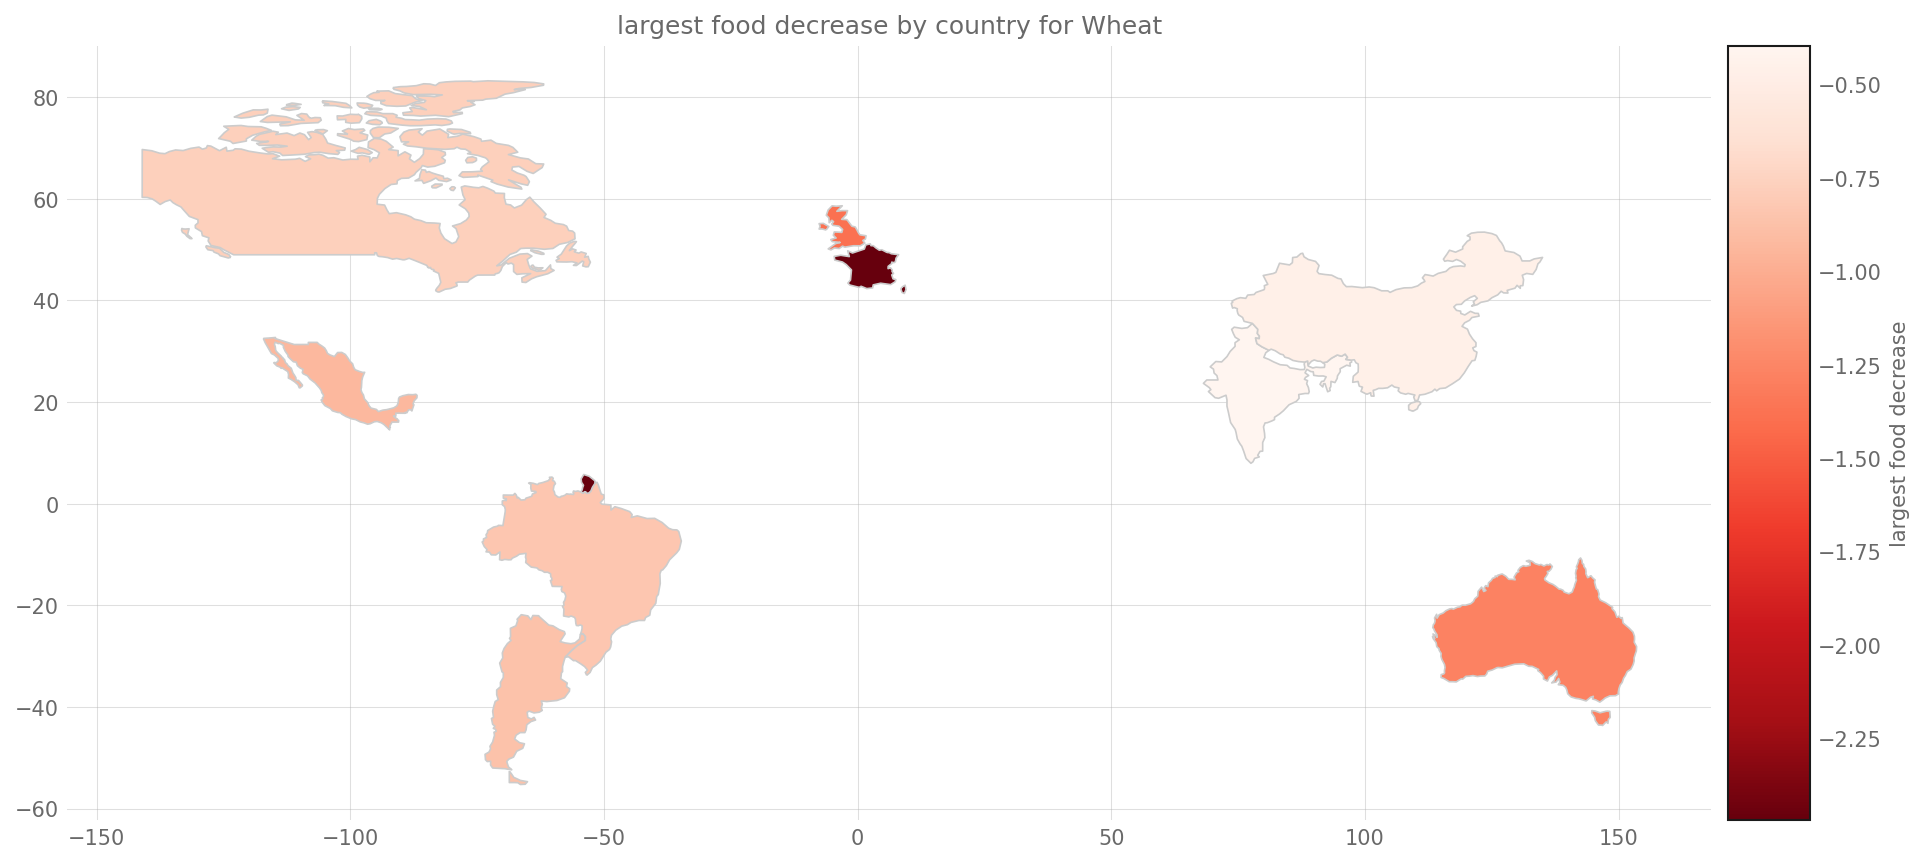

In [34]:
# get yearly change in crop yield per country (separate for wheat and maize)
new_crop_stats_country_df['yearly_yield_change'] = new_crop_stats_country_df.groupby(['crop', 'country'])['yield_per_country'].diff()

# load the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# loop through each crop type
for crop in crops: 

    # finding the largest decrease (food shock) for the specific crop
    largest_decreases = new_crop_stats_country_df[new_crop_stats_country_df['crop'] == crop].groupby('country')['yearly_yield_change'].min().reset_index()

    # merge the world map with the largest decreases data for the specific crop
    merged = world.set_index('name').join(largest_decreases.set_index('country'))

    # setup figure and axis
    fig, ax = plt.subplots(1, 1, figsize=(15, 25))

    # adjust colorbar size and add a label
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    merged.plot(column='yearly_yield_change', cmap='Reds_r', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, cax=cax)
    cax.set_ylabel('largest food decrease')

    ax.set_title(f'largest food decrease by country for {crop.capitalize()}')
    plt.savefig(f"{pathout_plots}max_food_shock_{crop}.png", bbox_inches='tight', dpi=300)
    
    plt.show()

## Conclusions, caveats, & future outlook

### conclusions

* Country-level yield changes: variances for both maize and wheat increase over time , i.e., larger changes compared to the previous year occur on both sides (i.e., it's less or more compared to the previous year), but more so for maize (for wheat, variances increase or stay the same).

* Global yield changes: On a global scale, the variance for maize clearly increases over time (as of ~1980) while the one for wheat does so only slightly (or remains the same) - this might be, in part, an effect of eliminating high variance countries for wheat from the list of big production countries. This is okay, given that we are interested in global-scale crop changes/decrease where country size matters.

* Overall, we experience greater changes in crop yield - both negative and positive - since roughly 1980 (in large magnitude particularly for maize). Whether this can be defined as an anomalous period will depend on how we situate/judge this increasing variance from a long-term perspective. Independent of that, increasing variance in crop yield changes seem concerning, as this is tantamount to less stability (spanning over decades - a time-scale that may be highly relevant for the well-being of humans on species-level).

* What is also concerning is that the largest food decreases occur in economically strong countries, e.g., United States, France, Australia (concerning because they do drive world economics, provide food to other places as well, and nurture larger population sizes).

### caveats

* There are a few degrees of freedom in the analysis presented here:
    - I've been including only those countries in the final dataset to get global yield that have contributed collectively to 95% of world's crop tonnes in 2010 - a different procedure could have been used to account for the fact that country size plays a major role in global variables. 
    - I decided to use a simple interpolation method which was linear - although other methods did not prove superior (and the number of values interpolated was small in the first place), it nonetheless may have not been the best procedure; also, I decided against forecasting (either before or after the last available datapoint where large chunks of time sections were missing), as data amounts seemed overall sufficient and forecasting methods didn't yield reasonably looking time series.
    - Instead of aggregating over region data right at the beginning, I could have taken a region-based approach first (e.g., interpolate using region data where available), but having done this first, it didn't yield any better results, so I eventually opted for the easier way. Nonetheless, this influenced the way I arrived at my global yield change dataset, and because this could have been done differently, it is another source of variance in the analysis.

### future outlook
- Inspect increasing variance more: quantify variance change more precisely and visualize this,
- components in country-level crop yield time series could be inspected using either Principal Component Analysis or some other time-series-specific decomposition method - this could shed light on different influencing factors driven by different countries that so far have been missed here,
- statistically test the hypothesis about an increasing trend or anomalous time period,
- improve global scale aggregation (e.g., weight data instead of excluding countries),
- more tests, such as end-to-end tests of the analysis.